In [584]:
import pandas as pd
import numpy as np
import pytz
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import plot_precision_recall_curve
from sklearn.feature_extraction.text import TfidfVectorizer 
import seaborn as sns
from custom_scripts import *

%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

# Trading on Sentiment

### Modeling Notebook

This notebook begins with two baseline models:
- Baseline with only price data.
- Baseline with only NLP data.

All subsequent models are attempts to improve the performance of the baseline models.

###### Importing the Daily Aggregated Data

In [585]:
data = pd.read_pickle("main_data/maindf.pkl")
data.increase = data.increase.astype(int)

Using the `thresh` custom method, i'll apply the target labels using the day_change column. The threshold is the share amount change from [Day A open] to [Day B open].Current threshold is set to (.055) maintain class balance in for the 0/1 targets.

In [586]:
# add the targets to the main dataframe. 
data['target'] = data['day_change'].apply(thresh)
data.target.value_counts()

0    694
1    691
Name: target, dtype: int64

# Splitting Data

In [587]:
X = data.drop(columns=['increase', 'target'], axis=1)
y = data.target

In [588]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [589]:
print(X_train.shape, y_train.shape, y_test.shape)

(1108, 10) (1108,) (277,)


# Baseline Model (only price data) 

This model will be used to determine if predictions using sentiment and NLP alone generate any meaningful results compared to just using the days historical price information. 

In [590]:
no_nlp_xtrain = X_train.drop(columns=['sent_negative', 'sent_positive', 'total_articles', 'tokens'])
no_nlp_xtest = X_test.drop(columns=['sent_negative', 'sent_positive', 'total_articles', 'tokens'])

In [591]:
no_nlp_dummy_clf = DummyClassifier()

no_nlp_dummy_clf.fit(no_nlp_xtrain, y_train)

#predictions made only with price information
no_nlp_preds = no_nlp_dummy_clf.predict(no_nlp_xtest)

We can see from the printout below that our baseline model with only basic financial data (open/close/volume) has an overall F1 score of .45, meaning that it performs slightly worse than random guessing as a whole. Whats more important for out purposes is the recall score for the positive class (1). We want to know: "of all the 1's our model predicted, how many were actually 1's"

In [592]:
no_nlp_f1 = metrics.f1_score(y_test, no_nlp_preds)
print(no_nlp_f1)
print("-"*60)                         
print(classification_report(y_test, no_nlp_preds))

0.5070422535211268
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.53      0.44      0.48       148
           1       0.46      0.56      0.51       129

    accuracy                           0.49       277
   macro avg       0.50      0.50      0.49       277
weighted avg       0.50      0.49      0.49       277



Now that we ran the baseline without NLP data, we can drop the price data and proceed with only NLP data. 

In [593]:
X_train.drop(columns=['open', 'high', 
                 'low', 'close', 'volume',
                'day_change', 'total_articles'], inplace=True)

X_test.drop(columns=['open', 'high', 
                 'low', 'close', 'volume',
                'day_change', 'total_articles'], inplace=True)

# TFIDF X_train

In [594]:
%%time

rf_feats = X_train.tokens.values
tfidfconverter = TfidfVectorizer(max_features=500, ngram_range=(1,3))  

X = tfidfconverter.fit_transform(rf_feats).toarray()

tfidf_train = pd.DataFrame(X)

CPU times: user 55.6 s, sys: 2.1 s, total: 57.7 s
Wall time: 58.2 s


In [595]:
X_train = X_train.reset_index(drop=True)
frames = [X_train, tfidf_train]
X_train = pd.concat(frames, axis=1) 

# TFIDF X_test

In [596]:
%%time
rf_feats = X_test.tokens.values
tfidfconverter = TfidfVectorizer(max_features=500, ngram_range=(1,3))  

X = tfidfconverter.fit_transform(rf_feats).toarray()

tfidf_test = pd.DataFrame(X)

CPU times: user 13.9 s, sys: 505 ms, total: 14.4 s
Wall time: 14.5 s


In [597]:
X_test = X_test.reset_index(drop=True)
frames = [X_test, tfidf_test]
X_test = pd.concat(frames, axis=1) 

In [598]:
X_train.drop(columns=['tokens'], inplace=True)
X_test.drop(columns=['tokens'], inplace=True)

# Baseline Model

This model will be used to judge against the performance of all subsequent models.

In [599]:
dummy_clf = DummyClassifier(strategy="stratified")

In [600]:
dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='stratified')

In [601]:
dum_preds = dummy_clf.predict(X_test)

The NLP dummy classifier performs similarly to the previous dummy classifier with an overall F1 score of .45-.50. Recall on the positive class (1) is slightly decreased from only financial data. 

In [602]:
dummy_f1 = metrics.f1_score(y_test, dum_preds)
print("F1 is:", dummy_f1)
print("-"*60)                         
print(classification_report(y_test, dum_preds))

F1 is: 0.5182481751824817
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.56      0.50      0.53       148
           1       0.49      0.55      0.52       129

    accuracy                           0.52       277
   macro avg       0.53      0.53      0.52       277
weighted avg       0.53      0.52      0.52       277



We can use ROC curves to visualize the general predictive accuracy of our models. We can see below that if you gave this dummy classifier one days worth of aggregated news articles related to apple stock, there is a .49 chance it would predict the positive class (that the stock will rise tomorrow). Ideally we want the blue line to be as close to the upper left corner of the plot as possible. We can use the ROC curve to determine optimal decision boundries based on our problem. I our case we want to predict all the days that a stock will increase. To do this we will attempt to optimize the recall score. If we throw today's news at our model, we want the the ability of our model to choose if the stock will increase tomorrow to be high. 

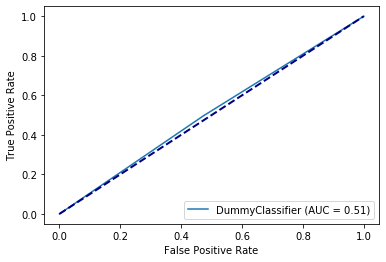

In [604]:
plot_roc_curve(dummy_clf, X_test, y_test);
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');

# Random Forest

In [605]:
%%time
rfc = RandomForestClassifier(criterion = "gini",
                             random_state = 0,
                             verbose=1, n_jobs=-1)



CPU times: user 91 µs, sys: 240 µs, total: 331 µs
Wall time: 335 µs


In [606]:
param_dict={'min_samples_leaf':[1,2,4],
            'max_depth': [1, 2,10,45],
           'n_estimators':[10, 15, 20, 25]}

In [607]:
%%time
grid_tree = GridSearchCV(rfc, param_dict, cv=10, scoring="recall", verbose=1, n_jobs=-1)

CPU times: user 56 µs, sys: 54 µs, total: 110 µs
Wall time: 113 µs


In [608]:
%%time
grid_tree.fit(X_train, y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   23.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.0s finished


CPU times: user 2.81 s, sys: 289 ms, total: 3.1 s
Wall time: 23.5 s


GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=0,
                                              verbose=1),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 10, 45],
                         'min_samples_leaf': [1, 2, 4],
                         'n_estimators': [10, 15, 20, 25]},
             scoring='recall', verbose=1)

In [609]:
grid_tree_pred = grid_tree.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished


The Random Forest model performs slightly better than random quessing overall, however, similar to upcoming models will predict more false positives than true positives. With 66% recall, the model does a moderate job of picking the positive class. 

In [610]:
random_forest_f1 = metrics.f1_score(y_test, grid_tree_pred)
print("F1 is:", random_forest_f1)
print("-"*60)   
print(classification_report(y_test, grid_tree_pred))

F1 is: 0.5483870967741936
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.54      0.35      0.43       148
           1       0.47      0.66      0.55       129

    accuracy                           0.49       277
   macro avg       0.51      0.51      0.49       277
weighted avg       0.51      0.49      0.48       277



In [611]:
print(grid_tree.best_params_)

{'max_depth': 1, 'min_samples_leaf': 1, 'n_estimators': 20}


In [612]:
confusion_matrix(y_test, grid_tree_pred)

array([[52, 96],
       [44, 85]])

# Bournoulli Naive Bayes

In [613]:
boo = BernoulliNB()

In [614]:
# I will use these parameters to grid search all subsequent Bayes Models
param_dict={'alpha':list(np.linspace(0,30,100))}

In [615]:
boo_nb = GridSearchCV(boo, param_dict, cv=5, scoring="recall", n_jobs=-1)

In [616]:
%%time
boo_nb.fit(X_train, y_train)

CPU times: user 1.2 s, sys: 74.3 ms, total: 1.27 s
Wall time: 3.77 s


GridSearchCV(cv=5, estimator=BernoulliNB(), n_jobs=-1,
             param_grid={'alpha': [0.0, 0.30303030303030304, 0.6060606060606061,
                                   0.9090909090909092, 1.2121212121212122,
                                   1.5151515151515151, 1.8181818181818183,
                                   2.121212121212121, 2.4242424242424243,
                                   2.7272727272727275, 3.0303030303030303,
                                   3.3333333333333335, 3.6363636363636367,
                                   3.9393939393939394, 4.242424242424242,
                                   4.545454545454546, 4.848484848484849,
                                   5.151515151515151, 5.454545454545455,
                                   5.757575757575758, 6.0606060606060606,
                                   6.363636363636364, 6.666666666666667,
                                   6.96969696969697, 7.272727272727273,
                                   7.57575757575757

In [617]:
boo_nb_pred = boo_nb.predict(X_test)

In [619]:
confusion_matrix(y_test, boo_nb_pred)

array([[63, 85],
       [49, 80]])

The Bournoulli Naive Bayes model performs only slightly better than someone who only has the days basic financial data. 

In [620]:
boo_f1 = metrics.f1_score(y_test, boo_nb_pred)
print("F1 is:", boo_f1)
print("-"*60)   
print(classification_report(y_test, boo_nb_pred))

F1 is: 0.54421768707483
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.56      0.43      0.48       148
           1       0.48      0.62      0.54       129

    accuracy                           0.52       277
   macro avg       0.52      0.52      0.51       277
weighted avg       0.53      0.52      0.51       277



In [621]:
# to be used in the combined plot of AUC across all models. 
boo_alpha = boo_nb.best_params_['alpha']

# Multinomial

In [622]:
from sklearn.naive_bayes import MultinomialNB

In [623]:
multi_clf = MultinomialNB()

In [624]:
multi_clf_grid = GridSearchCV(multi_clf, param_dict, cv=5, scoring="recall", n_jobs=-1)

In [625]:
%%time
multi_clf_grid.fit(X_train, y_train)

CPU times: user 1.47 s, sys: 93.1 ms, total: 1.56 s
Wall time: 3.17 s


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.0, 0.30303030303030304, 0.6060606060606061,
                                   0.9090909090909092, 1.2121212121212122,
                                   1.5151515151515151, 1.8181818181818183,
                                   2.121212121212121, 2.4242424242424243,
                                   2.7272727272727275, 3.0303030303030303,
                                   3.3333333333333335, 3.6363636363636367,
                                   3.9393939393939394, 4.242424242424242,
                                   4.545454545454546, 4.848484848484849,
                                   5.151515151515151, 5.454545454545455,
                                   5.757575757575758, 6.0606060606060606,
                                   6.363636363636364, 6.666666666666667,
                                   6.96969696969697, 7.272727272727273,
                                   7.575757575757

In [626]:
multi_clf_pred = multi_clf_grid.predict(X_test)

Overall, the Multinomial Naive Bayes model performs well, with an overall F1 score of 62% it predicts with better accuracy than random guessing. From the confusion matrix, we can see that the model does tend to primarily predict the positive class. The high false positive rate explains the 48% accuracy output. This model appears to have the most promise because it does a good job of correctly picking the positive examples. We can use the `class_prior` hyperparameter to adjust the decision boundry and see if we can lower the number of false positives. 

In [627]:
multi_f1 = metrics.f1_score(y_test, multi_clf_pred)
print("F1 is:", multi_f1)
print("-"*60)   
print(classification_report(y_test, multi_clf_pred))

F1 is: 0.6230366492146596
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.58      0.09      0.16       148
           1       0.47      0.92      0.62       129

    accuracy                           0.48       277
   macro avg       0.53      0.51      0.39       277
weighted avg       0.53      0.48      0.38       277



In [628]:
confusion_matrix(y_test, multi_clf_pred)

array([[ 14, 134],
       [ 10, 119]])

In [629]:
# to be used in the combined plot of AUC across all models.
multi_alpha = multi_clf_grid.best_params_['alpha']

# Gaussian NB

In [630]:
from sklearn.naive_bayes import GaussianNB

In [631]:
gaus_clf = GaussianNB()

In [632]:
param_grid = {
    "var_smoothing": list(np.linspace(0.0001,.00001,500))
}

In [633]:
gaus_clf_grid = GridSearchCV(gaus_clf, param_grid=param_grid, cv=5, scoring="recall", verbose=1, n_jobs=-1)

In [634]:
gaus_clf_grid.fit(X_train,y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 2452 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:   20.6s finished


GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [0.0001, 9.981963927855712e-05,
                                           9.963927855711424e-05,
                                           9.945891783567135e-05,
                                           9.927855711422846e-05,
                                           9.909819639278557e-05,
                                           9.891783567134269e-05,
                                           9.87374749498998e-05,
                                           9.855711422845692e-05,
                                           9.837675350701404e-05,
                                           9.819639278557115e-05,
                                           9.801603206412827e-05,
                                           9.783567134268537e-05,...
                                           9.729458917835672e-05,
                                           9.711422845691383e-05,
            

In [635]:
y_hat_gaus = gaus_clf_grid.predict(X_test)

The Gaussian Naive Bayes model predicts the positive class (that share prices will increase the following day) correctly 73% of the time, however, as we can see from the confusion matrix it predicts more false positives (102) than true positives (94). For our purposes, we want to more true positives than false positives. 

In [636]:
gaus_f1 = metrics.f1_score(y_test, y_hat_gaus)
print("F1 is:", gaus_f1)
print("-"*60)   
print(classification_report(y_test, y_hat_gaus))

F1 is: 0.5784615384615385
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.57      0.31      0.40       148
           1       0.48      0.73      0.58       129

    accuracy                           0.51       277
   macro avg       0.52      0.52      0.49       277
weighted avg       0.53      0.51      0.48       277



In [637]:
confusion_matrix(y_test, y_hat_gaus)

array([[ 46, 102],
       [ 35,  94]])

In [638]:
gaus_smoothing = gaus_clf_grid.best_params_['var_smoothing']

# Plotting The Modeling Results

In [653]:
from sklearn.metrics import roc_curve, roc_auc_score

In [654]:
models = [DummyClassifier(strategy="stratified"),
               MultinomialNB(alpha=multi_alpha),
               BernoulliNB(alpha=boo_alpha),
               GaussianNB(),
               RandomForestClassifier(n_estimators = 10, criterion = "entropy", random_state = 3)]

In [655]:
model_auc = pd.DataFrame(columns=['classifiers', 'fpr', 'tpr', 'auc'])

In [656]:
#Fit all of the models
for mod in models:
    mod = mod.fit(X_train, y_train)
    prob = mod.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  prob)
    auc = roc_auc_score(y_test, prob)
    
    model_auc = model_auc.append({'classifiers':mod.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

In [657]:
model_auc.set_index('classifiers', inplace=True)

In [658]:
model_auc

,fpr,tpr,auc
classifiers,,,
DummyClassifier,"[0.0, 0.5540540540540541, 1.0]","[0.0, 0.4728682170542636, 1.0]",0.459407
MultinomialNB,"[0.0, 0.006756756756756757, 0.0067567567567567...","[0.0, 0.0, 0.007751937984496124, 0.00775193798...",0.524984
BernoulliNB,"[0.0, 0.006756756756756757, 0.0202702702702702...","[0.0, 0.0, 0.0, 0.015503875968992248, 0.015503...",0.516132
GaussianNB,"[0.0, 0.02702702702702703, 0.03378378378378378...","[0.0, 0.015503875968992248, 0.0155038759689922...",0.540960
RandomForestClassifier,"[0.0, 0.013513513513513514, 0.0675675675675675...","[0.0, 0.0, 0.03875968992248062, 0.108527131782...",0.477818


We can see below that the Gaussian Naive Bayes classifier has the highest AUC, with Multinomial Naive Bayes taking second place. Ideally, these curves would be in the top left corner of the graph, suggesting that our data provides only a marginal increase in predictive power compares to random guessing.

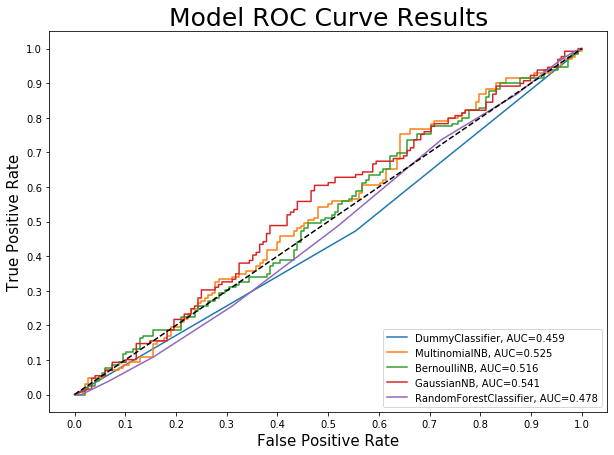

In [659]:
fig = plt.figure(figsize=(10,7))

for i in model_auc.index:
    plt.plot(model_auc.loc[i]['fpr'], 
             model_auc.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, model_auc.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='black', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('Model ROC Curve Results', fontsize=25)
plt.legend(prop={'size':10}, loc='lower right')

plt.savefig('model_analysis.png')

In [711]:
f1_scores = {'no_nlp':no_nlp_f1, 'dummy':dummy_f1, 'random_forest':random_forest_f1, 'bernoulli':boo_f1, 'multinomial':multi_f1, 'gaussian':gaus_f1}
f1_df = pd.DataFrame.from_dict(f1_scores, orient='index', columns=['F1_score'])

In [712]:
f1_df

,F1_score
no_nlp,0.507042
dummy,0.518248
random_forest,0.548387
bernoulli,0.544218
multinomial,0.623037
gaussian,0.578462


Although Gaussian Naive Bayes had the highest AUC, Multinomial Naive Bayes has the higher overall F1, which suggests that overall, Multinomial Naive Bayes may be a better model to perform our task. For this reason I will focus on improving the predictions of the Multinomial Naive Bayes model.   

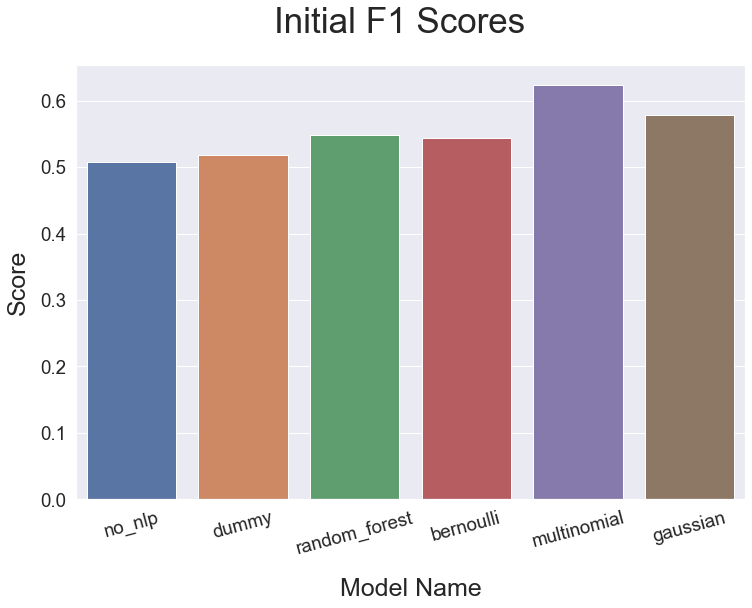

In [886]:
fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale = 1.7)
plt.xticks(rotation=15)
sns.barplot(data=f1_df, x=f1_df.index, y='F1_score')
fig.suptitle('Initial F1 Scores', fontsize=35)
plt.xlabel('Model Name', fontsize=25, labelpad=20)
plt.ylabel('Score', fontsize=25, labelpad=10);
plt.savefig('initial_f1.png')

# Final Model: Multinomial Naive Bayes

From the above graph, we can see that the Gaussian Naive Bayes model has the largest area under the curve (AUC). So why wouldn't we choose that model? If we look at the overall performance of both of the estimators we can see that the Multinomial Naive Bayes model has a higher overall F1, and also a much higher recall for the positive class. We can adjust the decision boundry to make sure our model predicts more true positives than false positive.

In [826]:
#class prior is set to .50 by default
final_clf = MultinomialNB(class_prior=[.50, .50])

param_dict={'alpha':list(np.linspace(0,30,100))}

final_clf_grid = GridSearchCV(final_clf, param_dict, cv=5, scoring="recall", n_jobs=-1)

final_clf_grid.fit(X_train, y_train)

final_clf_pred = final_clf_grid.predict(X_test)

Given the days news, this model predicts that the stock will rise the following day 91% of the time. Of those 91% of predictions, the model is correct for the positive class 63% of the time. This performance is better than random guessing, but not ideal because the model predicts the positive class most of the time. We can adjust the decision boundry with the `class_prior` hyperparameter in order to even out the variety of predictions the model is making. 

In [827]:
multi_f1 = metrics.f1_score(y_test, final_clf_pred)
print("F1 is:", multi_f1)
print("-"*60)   
print(classification_report(y_test, final_clf_pred))

F1 is: 0.6293333333333333
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.65      0.14      0.22       148
           1       0.48      0.91      0.63       129

    accuracy                           0.50       277
   macro avg       0.56      0.52      0.43       277
weighted avg       0.57      0.50      0.41       277



In [828]:
confusion_matrix(y_test, final_clf_pred)

array([[ 20, 128],
       [ 11, 118]])

##### Second Iteration

In [831]:
#modifying the decision boundry.
second_iteration_clf = MultinomialNB(class_prior=[.55, .45])

second_iteration_clf_grid = GridSearchCV(second_iteration_clf, param_dict, cv=5, scoring="recall", n_jobs=-1)

second_iteration_clf_grid.fit(X_train, y_train)

second_iteration_clf_pred = second_iteration_clf_grid.predict(X_test)

If we move the class prior over .50, we can see that the model starts to diversify its predictions at the cost of our recall score and overall F1 score. However, the overall acuuracy of the model improves. The problem is that the model is still predicting more false positives than true positives. Lets adjust the priors more to see if we can correct this. 

In [832]:
second_iter_f1 = metrics.f1_score(y_test, second_iteration_clf_pred)
print("F1 is:", second_iter_f1)
print("-"*60)   
print(classification_report(y_test, second_iteration_clf_pred))

F1 is: 0.6047904191616766
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.30      0.40       148
           1       0.49      0.78      0.60       129

    accuracy                           0.52       277
   macro avg       0.55      0.54      0.50       277
weighted avg       0.56      0.52      0.50       277



In [833]:
confusion_matrix(y_test, second_iteration_clf_pred)

array([[ 44, 104],
       [ 28, 101]])

##### Third Iteration

In [852]:
#modifying the decision boundry.
third_iteration_clf = MultinomialNB(class_prior=[.565, .44])

third_iteration_clf_grid = GridSearchCV(third_iteration_clf, param_dict, cv=5, scoring="recall", n_jobs=-1)

third_iteration_clf_grid.fit(X_train, y_train)

third_iteration_clf_pred = third_iteration_clf_grid.predict(X_test)

It's a small gain but overall our model now predicts stock increases more reliably than random guessing (10% more). Of the 129 days with the positive tag (stock increased by over 5 cents per share the next day), 74% were correctly identified by our model. Our AUC also increased by 3%.

In [853]:
third_iter_f1 = metrics.f1_score(y_test, third_iteration_clf_pred)
print("F1 is:", third_iter_f1)
print("-"*60)   
print(classification_report(y_test, third_iteration_clf_pred))

F1 is: 0.5999999999999999
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.62      0.36      0.45       148
           1       0.50      0.74      0.60       129

    accuracy                           0.54       277
   macro avg       0.56      0.55      0.53       277
weighted avg       0.56      0.54      0.52       277



In [854]:
confusion_matrix(y_test, third_iteration_clf_pred)

array([[53, 95],
       [33, 96]])

In [862]:
fin_auc = metrics.roc_auc_score(y_test, third_iteration_clf_pred)
print(f'Final AUC: {fin_auc}')

Final AUC: 0.551147077309868


#### Visualizing Results of the final model

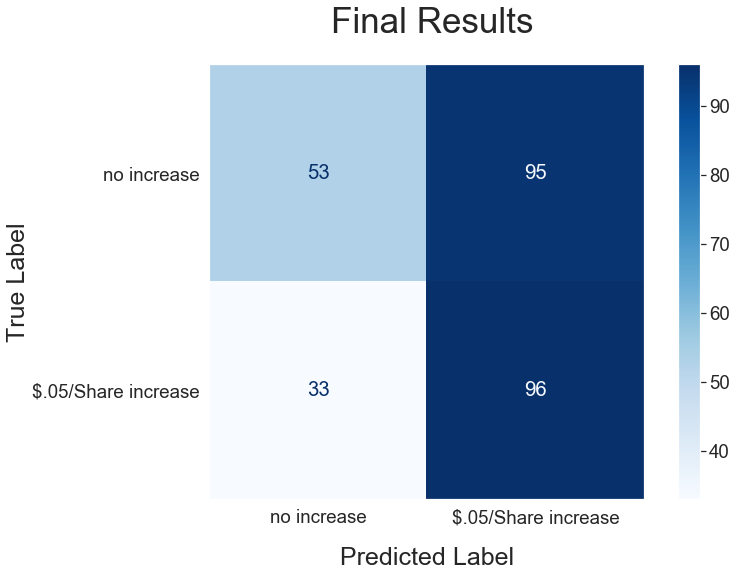

In [888]:
from sklearn.metrics import plot_confusion_matrix

class_names = ['no increase', '$.05/Share increase']


fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle('Final Results', fontsize=35)
plot_confusion_matrix(third_iteration_clf_grid, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues, ax=ax)
plt.xlabel('Predicted Label', fontsize=25, labelpad=20)
plt.ylabel('True Label', fontsize=25, labelpad=2);
ax.grid(False)
plt.savefig('final_confusion.png')

# Conclusions and Next Steps

As a guide for decision making, this model would have value in identifying days when investors may want to sell their Apple shares. However, the number of false positives produced by the model is too high to allow for automated trading. Additionally, I believe that adding more observations to the training and testing sets would benefit the model. It would also be interesting to compare the output of this model to a model that only took into account social media data. Then combine social media and news to see if predictions improve. 